## Goal of the notebook: Converting the gene expression data from Favate et al to a format that is compatible with the reannotated reference genome (using K12 proteins list)


doi: https://doi.org/10.1101/2021.01.12.426406

#### Complication: 
their dataset uses the locus tags (ECB_xxxx) from the original NC_12967 reference genome for REL606. This does not match up with the metadata I'm using.

#### Solution: 
For every gene in their version of the annotated genome, find the corresponding locus tag in the K12-based annotated genome (and construct a dictionary with this info). If an ECB locus is not present for one of our genes, then do not include in this comparison.

#### Output
Expression levels array: for every gene and every population analysed

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time
import pandas as pd
import re
from Bio.SeqIO.FastaIO import SimpleFastaParser
import seaborn as sns
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
import re
from Bio import pairwise2
import time
from Bio.SeqIO.QualityIO import FastqGeneralIterator

import pathlib
import os

In [7]:
import seaborn as sns
sns.set_theme()
sns.set_style('white')
sns.set_context('paper')


In [8]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper/Analysis/Part_3_TnSeq_analysis/Exploratory_analysis


In [33]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the breseq output data
path = pathlib.Path(cwd)
repo = path.parents[2]
print(repo) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper


In [10]:
metadata_path = str(path.parents[2])+'/Metadata/'

In [12]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"/all_metadata_REL606.txt", sep="\t")
names = all_data.iloc[:,0]
gene_start = all_data.iloc[:,3]
gene_end = all_data.iloc[:,4]
strand = all_data.iloc[:,5]
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
uniprot_rel606 = all_data.iloc[:,6]

libraries = ['REL606', 'REL607', 'REL11330', 'REL11333', 'REL11364', 'REL11336', 'REL11339', 'REL11389', 'REL11392', 'REL11342', 'REL11345', 'REL11348', 'REL11367', 'REL11370']

Loading the original genbank file for REL606

In [13]:
gb_file = metadata_path+"/sequence_NC_12967.gb"
gb_record = SeqIO.read(open(gb_file,"r"), "genbank")
print("Name %s, %i features" % (gb_record.name, len(gb_record.features)))
print(repr(gb_record.seq))

Name NC_012967, 8910 features
Seq('AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAG...TTC')


In [14]:
feature_count = 0
for i in range(0,len(gb_record.features)):
    gb_feature = gb_record.features[i]
    if gb_feature.type == 'CDS' and 'old_locus_tag' in gb_feature.qualifiers and 'pseudo' not in gb_feature.qualifiers and "IS" not in gb_feature.qualifiers["product"][0]:
        feature_count+=1

In [15]:
locations_nc12967 = np.zeros([feature_count,3])

In [16]:
ecb_loci = []

In [17]:
j = 0
for i in range(0,len(gb_record.features)):
    gb_feature = gb_record.features[i]
    #check if feature is a CDS (coding sequence), and not a pseudogene or coding for IS element related machinery
    if gb_feature.type == 'CDS' and 'old_locus_tag' in gb_feature.qualifiers and 'pseudo' not in gb_feature.qualifiers and "IS" not in gb_feature.qualifiers["product"][0]:
        #strand on which gene is found
        locations_nc12967[j,2] = gb_feature.strand
        #gene on forward strand
        if gb_feature.strand == 1:
            locations_nc12967[j,0] = gb_feature.location.nofuzzy_start+1
            locations_nc12967[j,1] = gb_feature.location.nofuzzy_end
        #gene on reverse strand
        elif gb_feature.strand == -1:
            locations_nc12967[j,1] = gb_feature.location.nofuzzy_start+1
            locations_nc12967[j,0] = gb_feature.location.nofuzzy_end
        ecb_loci.append(gb_feature.qualifiers['old_locus_tag'])
        j+=1

In [19]:
ecb_loci[4000]

['ECB_04279']

### Constructing a mapping between the ECB loci and the K12 based annotations

In [20]:
dict1 = {}
for i in range(len(uniprot_rel606)):
    start = locations[i,0]
    end = locations[i,1]
    orientation = locations[i,2]
    search = np.where((locations_nc12967[:,1]==end)&(locations_nc12967[:,0]==start)&(locations_nc12967[:,2]==orientation))[0]
    if len(search==1):
        dict1[i] = ecb_loci[search[0]][0]

In [21]:
len(dict1)

3747

Excellent! 3747 genes out of the 4017 that we analyzed are mapped to a corresponding ECB Locus. Now we can begin looking at expression levels of essential vs non-essential genes in the different populations

In [12]:
#diff_essentiality_verified = np.loadtxt('/Users/anuraglimdi/github/tn-seq_data_analysis/novaseq_data_analysis/Redoing analysis/Data_for_figures/Differential_gene_essentiality.txt')

### Loading the rnaseq and the riboseq data from Favate et al.

In [22]:
expression_data = pd.read_csv(metadata_path+"/Favate_et_al_data_GSE164308_table_s1_read_counts.csv")

In [23]:
expression_data

,repl,seqtype,line,target_id,est_counts,eff_length,length,tpm
0,rep1,ribo,Ara-1,alaT,5005,51.9997,76,11248.254541
1,rep1,ribo,Ara-1,alaU,5005,51.9997,76,11248.254541
2,rep1,ribo,Ara-1,alaV,5005,51.9997,76,11248.254541
3,rep1,ribo,Ara-1,alaW,1345,51.9997,76,3022.757714
4,rep1,ribo,Ara-1,alaX,1345,51.9997,76,3022.757714
...,...,...,...,...,...,...,...,...
228379,rep2,rna,REL607,valV,9543,52.9997,77,4238.922172
228380,rep2,rna,REL607,valW,3025,52.9997,77,1343.680139
228381,rep2,rna,REL607,valX,17580,51.9997,76,7959.063377
228382,rep2,rna,REL607,valY,17580,51.9997,76,7959.063377


In [24]:
rnaseq=expression_data.loc[expression_data['seqtype'] == "rna"]
riboseq=expression_data.loc[expression_data['seqtype'] == "ribo"]

In [25]:
genes_compare = list(dict1.values())

In [26]:
rnaseq_compare = rnaseq.loc[rnaseq["target_id"].isin(genes_compare)]

In [27]:
pop_dict = {"REL606":"REL606", "REL607":"REL607", "REL11330":"Ara-1", "REL11333":"Ara-2", "REL11364":"Ara-3", 
           "REL11336":"Ara-4","REL11339":"Ara-5","REL11389":"Ara-6","REL11392":"Ara+1","REL11342":"Ara+2",
            "REL11345":"Ara+3","REL11348":"Ara+4","REL11367":"Ara+5","REL11370":"Ara+6"}

In [28]:
len(set(rnaseq_compare["line"]))

13

NOTE: Ara+6 is missing from their RNA-Seq and Ribo-Seq analysis (due to contamination during the library prepping)

In [29]:
expression_lvls = np.zeros([len(names),len(set(rnaseq_compare["line"])),2])

In [30]:
#iterating over populations excluding ara+6, which is missing from their data
for k in range(0,len(set(rnaseq_compare["line"]))):
    #iterating over genes in our annotation of the genome. Basically gonna search for the correspondng ecb locus for
    #every gene. If it is present in the rnaseq data, I'll extract the corresponding tpm counts for both replicates
    pop_search = pop_dict[libraries[k]]
    print(pop_search)
    rep1 = rnaseq_compare.loc[(rnaseq_compare['line']==pop_search) & (rnaseq_compare['repl']=="rep1"),('target_id','tpm')]
    rep2 = rnaseq_compare.loc[(rnaseq_compare['line']==pop_search) & (rnaseq_compare['repl']=="rep2"),('target_id','tpm')]
    targets = rep1["target_id"]
    #iterating over genes that are present in the dictionary
    for i in list(dict1.keys()):
        #if gene is present in the expression data:
        if dict1[i] in set(targets):
            expression_lvls[i,k,0] = float(rep1.loc[rep1["target_id"]==dict1[i], "tpm"])
            expression_lvls[i,k,1] = float(rep2.loc[rep2["target_id"]==dict1[i], "tpm"])

REL606
REL607
Ara-1
Ara-2
Ara-3
Ara-4
Ara-5
Ara-6
Ara+1
Ara+2
Ara+3
Ara+4
Ara+5


In [32]:
expression_mean = np.mean(expression_lvls,axis=2)

In [34]:
savepath = str(repo)+'/Analysis/Part_3_TnSeq_analysis/Processed_data_for_plotting/'

#### Saving the RNA expression data

There is no need to write to file, as the it already exists in the github repository. If you want to overwrite the existing files, after modifying some of the code shown above, uncomment the following code block:

In [64]:
#np.savetxt(savepath+'expression_means.txt', expression_mean)

### Quick visualization of their data (looking at technical correlation etc.)

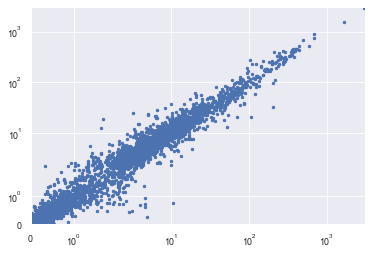

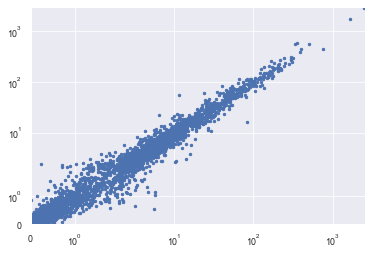

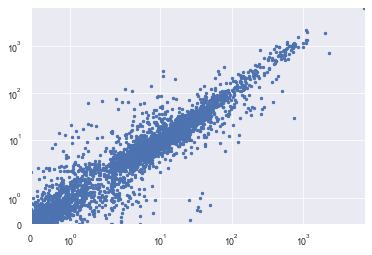

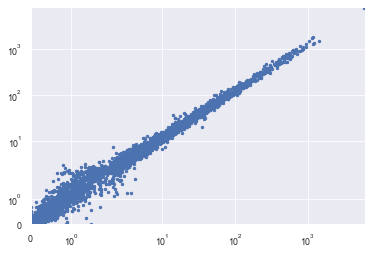

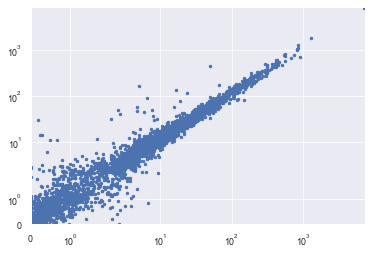

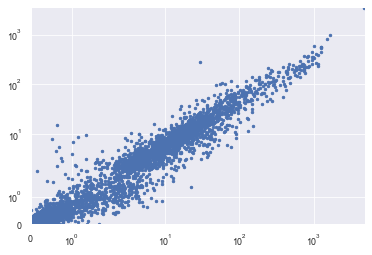

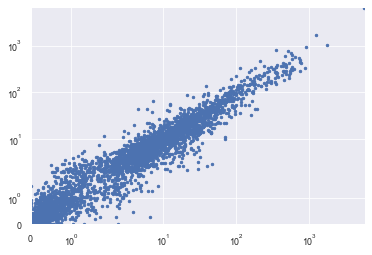

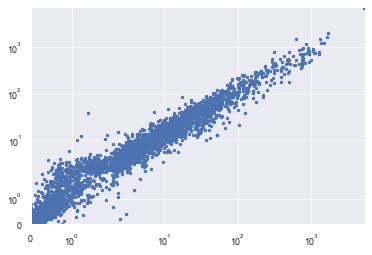

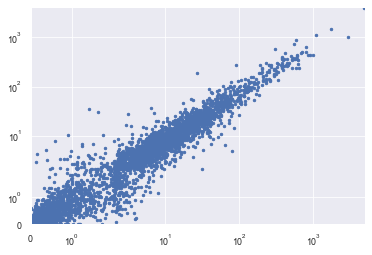

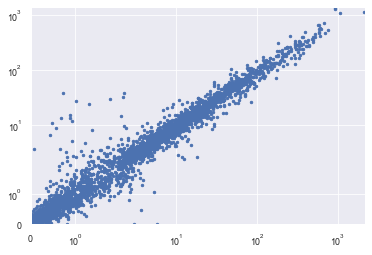

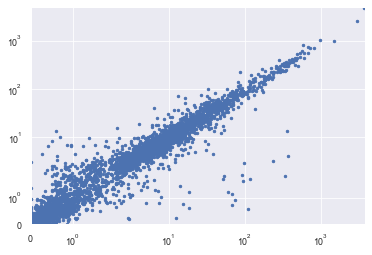

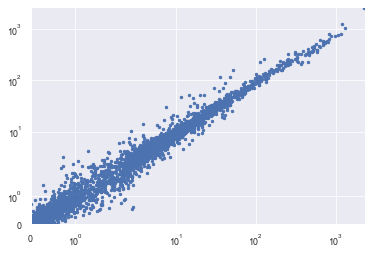

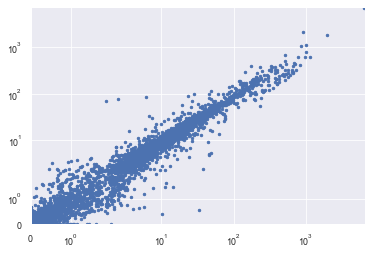

In [28]:
for k in range(0,len(set(rnaseq_compare["line"]))):
    plt.plot(expression_lvls[:,k,0],expression_lvls[:,k,1],'.')
    plt.xlim(0)
    plt.ylim(0)
    plt.yscale('symlog')
    plt.xscale('symlog')
    plt.show()

now, comparing expression levels between the ancestor and the evolved population

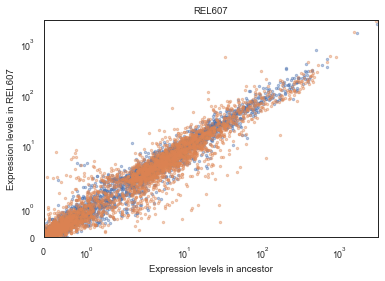

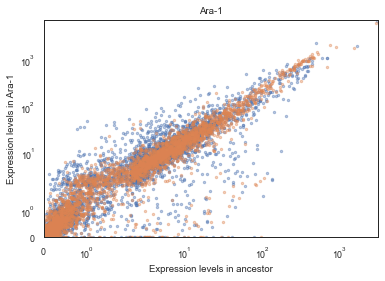

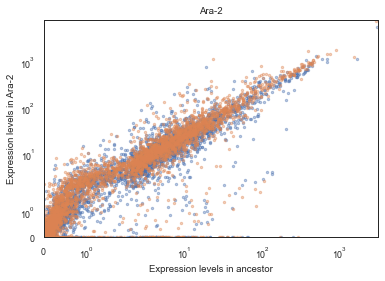

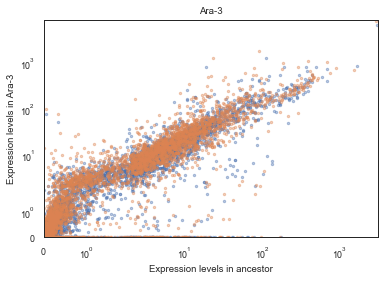

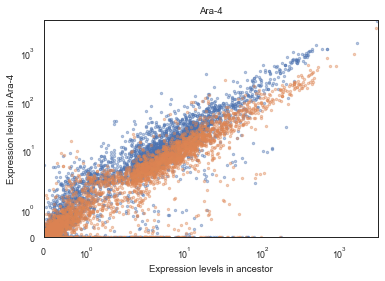

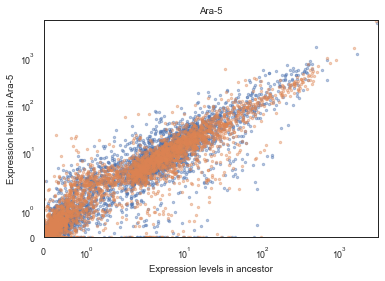

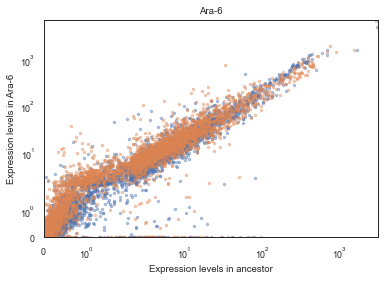

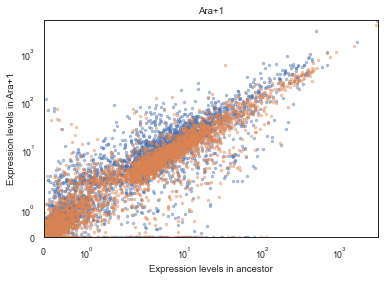

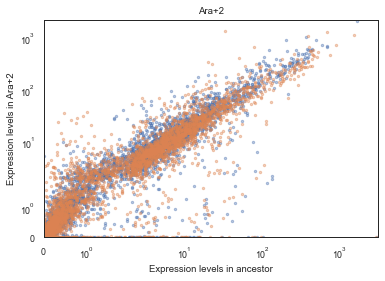

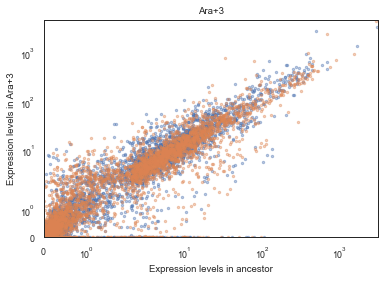

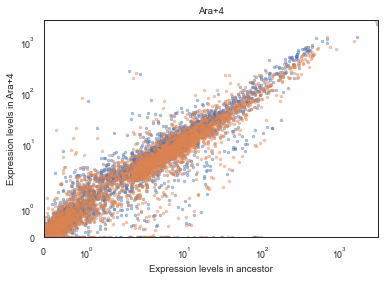

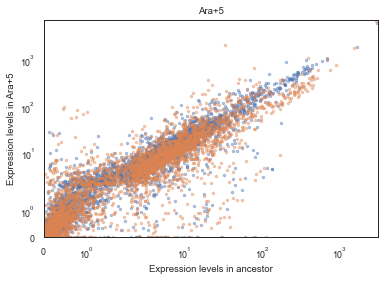

In [32]:
for k in range(1,len(set(rnaseq_compare["line"]))):
    plt.plot(expression_lvls[:,0,0],expression_lvls[:,k,0],'.',alpha=0.4)
    plt.plot(expression_lvls[:,0,1],expression_lvls[:,k,1],'.',alpha=0.4)
    plt.xlim(0)
    plt.ylim(0)
    plt.yscale('symlog')
    plt.xscale('symlog')
    plt.xlabel('Expression levels in ancestor')
    plt.ylabel(f'Expression levels in {pop_dict[libraries[k]]}')
    plt.title(pop_dict[libraries[k]])
    plt.show()

overall, their data is very reproducible, and there do seem to be some expression level differences in the ancestor and the evolved strains